In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Bu kod, veri ön işleme adımları için hazırlanmıştır. burada gerekli kütüphaneler import edilmiştir.

In [2]:
# Veri Önişleme

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import shutil
from pathlib import Path
import random

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Görselleştirme ayarları
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

Veri seti,Train-Validation-Test olarak bu kodda bölümlendirilmiştir.

In [3]:
#train-validation-test setlerine ayrılması

# Veri seti yolları
data_dir = "/kaggle/input/intel-image-classification/"
original_train_dir = os.path.join(data_dir, "seg_train/seg_train")
original_test_dir = os.path.join(data_dir, "seg_test/seg_test")

# Yeni bölünmüş veriler için dizin yapısı
base_dir = "/kaggle/working/split_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Sınıf isimleri
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Bölünme oranları
train_ratio = 0.70
val_ratio = 0.14
test_ratio = 0.16  # Toplamın 1 olması için küçük ayar

print("Sınıf isimleri:", class_names)
print("Bölünme oranları - Train: {}, Val: {}, Test: {}".format(train_ratio, val_ratio, test_ratio))

Sınıf isimleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Bölünme oranları - Train: 0.7, Val: 0.14, Test: 0.16


Veri seti içerisindeki sınıfların resim sayılarının çıktısını verir.

In [4]:
def calculate_dataset_stats(directory, class_names):
    """Veri seti istatistiklerini hesaplar"""
    stats = {}
    total_images = 0
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            stats[class_name] = num_images
            total_images += num_images
    
    stats['total'] = total_images
    return stats

# Orijinal veri seti istatistikleri
original_train_stats = calculate_dataset_stats(original_train_dir, class_names)
original_test_stats = calculate_dataset_stats(original_test_dir, class_names)

print("=== ORİJİNAL VERİ SETİ İSTATİSTİKLERİ ===")
print("\nEğitim Seti:")
for class_name, count in original_train_stats.items():
    if class_name != 'total':
        print(f"  {class_name}: {count} resim")

print(f"\nToplam Eğitim Resimleri: {original_train_stats['total']}")

print("\nTest Seti:")
for class_name, count in original_test_stats.items():
    if class_name != 'total':
        print(f"  {class_name}: {count} resim")

print(f"\nToplam Test Resimleri: {original_test_stats['total']}")

=== ORİJİNAL VERİ SETİ İSTATİSTİKLERİ ===

Eğitim Seti:
  buildings: 2191 resim
  forest: 2271 resim
  glacier: 2404 resim
  mountain: 2512 resim
  sea: 2274 resim
  street: 2382 resim

Toplam Eğitim Resimleri: 14034

Test Seti:
  buildings: 437 resim
  forest: 474 resim
  glacier: 553 resim
  mountain: 525 resim
  sea: 510 resim
  street: 501 resim

Toplam Test Resimleri: 3000


Bölümlendirilmiş Train-Validation-Test verilerinin resim sayısını belirlemektedir.

In [5]:
def create_directory_structure():
    """Dizin yapısını oluşturur"""
    for directory in [train_dir, val_dir, test_dir]:
        for class_name in class_names:
            Path(os.path.join(directory, class_name)).mkdir(parents=True, exist_ok=True)

def split_dataset():
    """Veri setini train-val-test olarak böler"""
    
    # Önce dizin yapısını oluştur
    create_directory_structure()
    
    # Tüm veriyi topla ve karıştır
    all_images = []
    
    for class_name in class_names:
        class_path = os.path.join(original_train_dir, class_name)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                 if img.endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_path in images:
            all_images.append((img_path, class_name))
    
    # Veriyi karıştır
    random.shuffle(all_images)
    
    # Bölme işlemleri
    total_size = len(all_images)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    
    # Veriyi böl
    train_images = all_images[:train_size]
    val_images = all_images[train_size:train_size + val_size]
    test_images = all_images[train_size + val_size:]
    
    # Dosyaları kopyala
    def copy_images(image_list, destination_dir):
        for img_path, class_name in image_list:
            filename = os.path.basename(img_path)
            dest_path = os.path.join(destination_dir, class_name, filename)
            shutil.copy2(img_path, dest_path)
    
    print("Dosyalar kopyalanıyor...")
    copy_images(train_images, train_dir)
    copy_images(val_images, val_dir)
    copy_images(test_images, test_dir)
    
    print("Bölme işlemi tamamlandı!")
    return len(train_images), len(val_images), len(test_images)

# Veriyi bölelim
train_count, val_count, test_count = split_dataset()

print(f"\n=== BÖLÜNMÜŞ VERİ SETİ İSTATİSTİKLERİ ===")
print(f"Eğitim Seti: {train_count} resim ({train_count/(train_count+val_count+test_count)*100:.1f}%)")
print(f"Validation Seti: {val_count} resim ({val_count/(train_count+val_count+test_count)*100:.1f}%)")
print(f"Test Seti: {test_count} resim ({test_count/(train_count+val_count+test_count)*100:.1f}%)")

Dosyalar kopyalanıyor...
Bölme işlemi tamamlandı!

=== BÖLÜNMÜŞ VERİ SETİ İSTATİSTİKLERİ ===
Eğitim Seti: 9823 resim (70.0%)
Validation Seti: 1964 resim (14.0%)
Test Seti: 2247 resim (16.0%)


Bu kod, veri seti dağılımının grafiklerini görselleştirmektedir. Ayrıca, sınıfların Train-Validation-Test miktarını belirlemiştir.

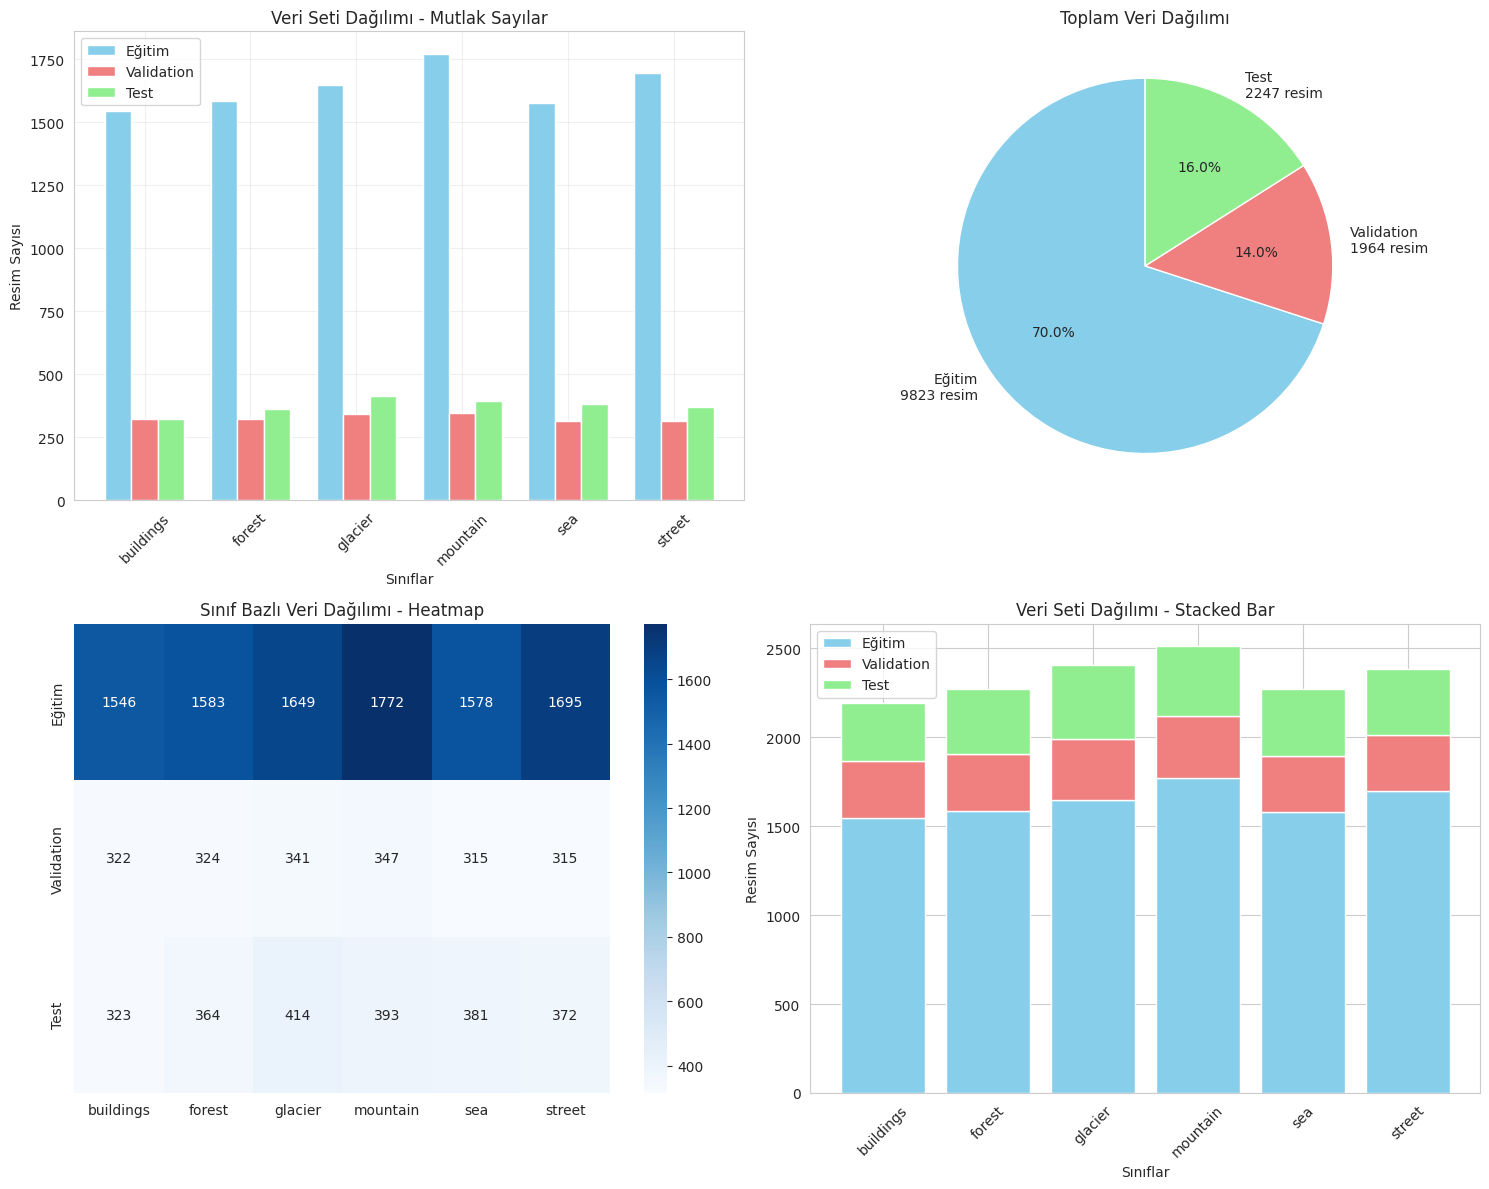


=== DETAYLI SINIF BAZLI İSTATİSTİKLER ===
       Sınıf  Eğitim  Validation  Test  Toplam
0  buildings    1546         322   323    2191
1     forest    1583         324   364    2271
2    glacier    1649         341   414    2404
3   mountain    1772         347   393    2512
4        sea    1578         315   381    2274
5     street    1695         315   372    2382


In [6]:
#Dağılım grafikleri

def plot_dataset_distribution():
    """Veri seti dağılımını görselleştirir"""
    
    # Sınıf bazlı sayıları hesapla
    train_class_counts = []
    val_class_counts = []
    test_class_counts = []
    
    for class_name in class_names:
        train_class_counts.append(len(os.listdir(os.path.join(train_dir, class_name))))
        val_class_counts.append(len(os.listdir(os.path.join(val_dir, class_name))))
        test_class_counts.append(len(os.listdir(os.path.join(test_dir, class_name))))
    
    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Çubuk grafik - Mutlak sayılar
    x = np.arange(len(class_names))
    width = 0.25
    
    axes[0, 0].bar(x - width, train_class_counts, width, label='Eğitim', color='skyblue')
    axes[0, 0].bar(x, val_class_counts, width, label='Validation', color='lightcoral')
    axes[0, 0].bar(x + width, test_class_counts, width, label='Test', color='lightgreen')
    axes[0, 0].set_title('Veri Seti Dağılımı - Mutlak Sayılar')
    axes[0, 0].set_xlabel('Sınıflar')
    axes[0, 0].set_ylabel('Resim Sayısı')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(class_names, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Pasta grafik - Oranlar
    sizes = [train_count, val_count, test_count]
    labels = [f'Eğitim\n{train_count} resim', f'Validation\n{val_count} resim', f'Test\n{test_count} resim']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    axes[0, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Toplam Veri Dağılımı')
    
    # 3. Heatmap - Sınıf bazlı dağılım
    distribution_data = np.array([train_class_counts, val_class_counts, test_class_counts])
    sns.heatmap(distribution_data, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=['Eğitim', 'Validation', 'Test'], 
                ax=axes[1, 0])
    axes[1, 0].set_title('Sınıf Bazlı Veri Dağılımı - Heatmap')
    
    # 4. Stacked bar chart
    axes[1, 1].bar(class_names, train_class_counts, label='Eğitim', color='skyblue')
    axes[1, 1].bar(class_names, val_class_counts, bottom=train_class_counts, label='Validation', color='lightcoral')
    axes[1, 1].bar(class_names, test_class_counts, 
                  bottom=np.array(train_class_counts) + np.array(val_class_counts), 
                  label='Test', color='lightgreen')
    axes[1, 1].set_title('Veri Seti Dağılımı - Stacked Bar')
    axes[1, 1].set_xlabel('Sınıflar')
    axes[1, 1].set_ylabel('Resim Sayısı')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # İstatistiksel bilgiler
    print("\n=== DETAYLI SINIF BAZLI İSTATİSTİKLER ===")
    stats_df = pd.DataFrame({
        'Sınıf': class_names,
        'Eğitim': train_class_counts,
        'Validation': val_class_counts,
        'Test': test_class_counts,
        'Toplam': np.array(train_class_counts) + np.array(val_class_counts) + np.array(test_class_counts)
    })
    
    print(stats_df)

# Görselleştirmeyi çalıştır
plot_dataset_distribution()

Veri setinde bulunan her sınıfdan iki adet görseli temsil etmektedir.

Her sınıftan 2 örnek görüntü:


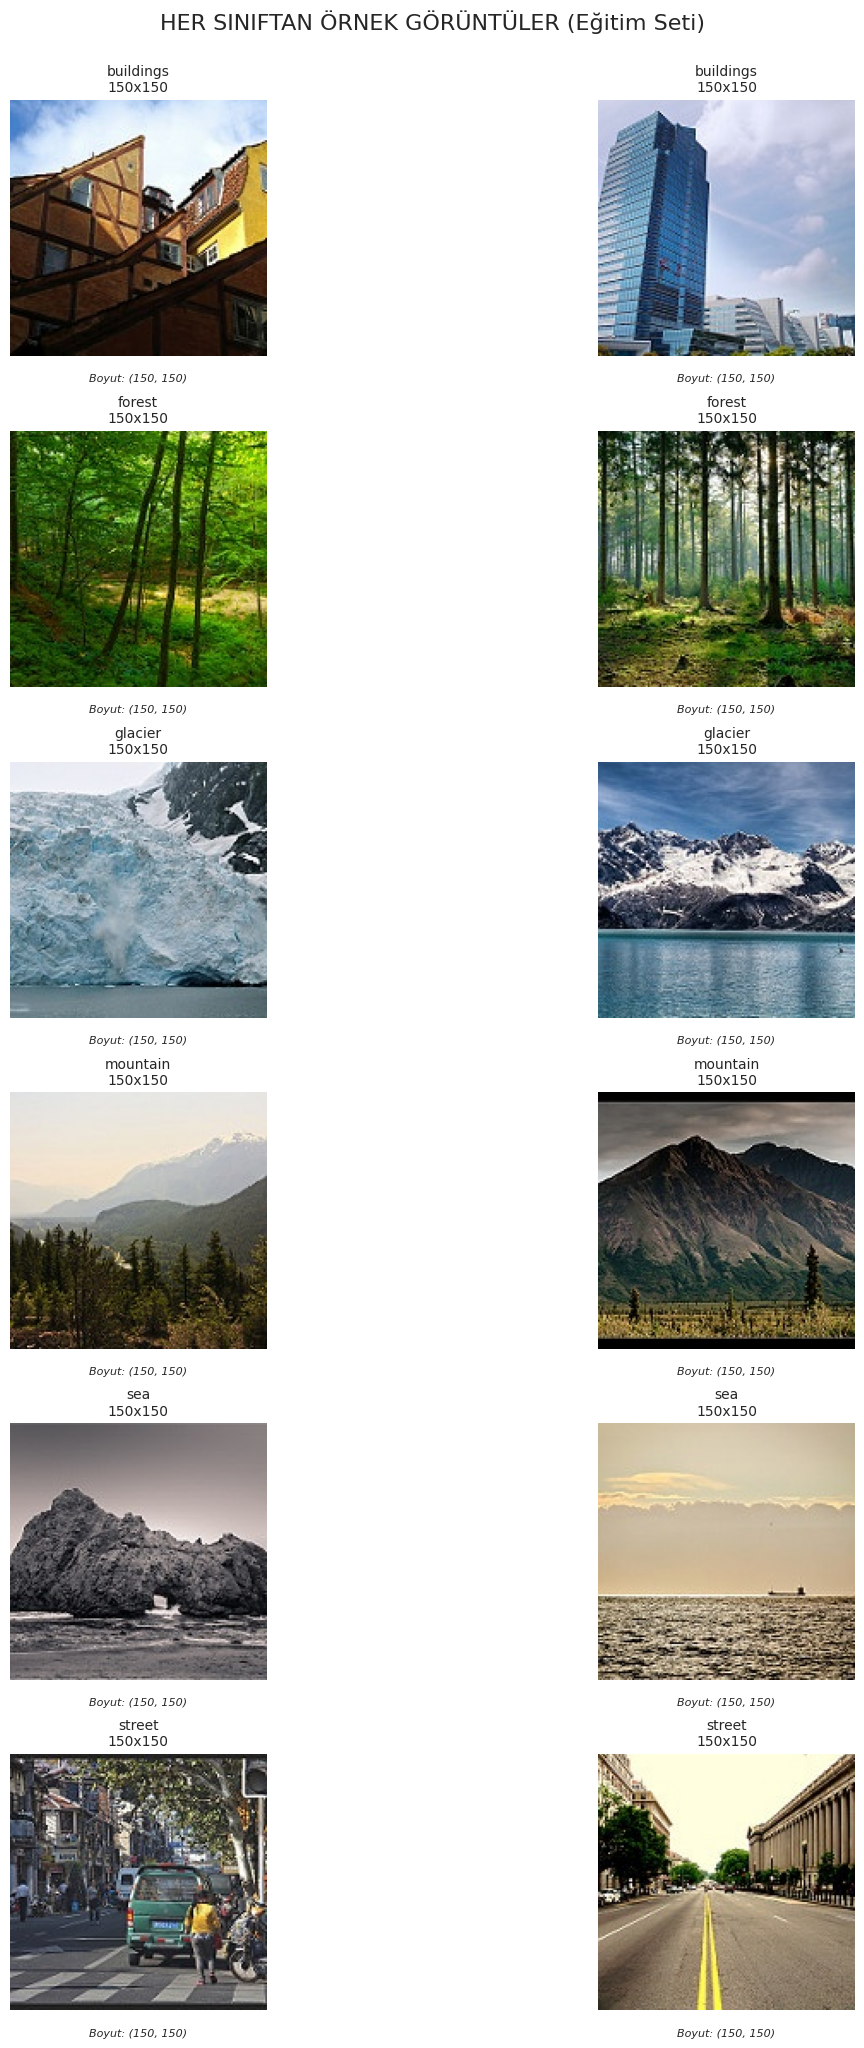

In [7]:
#Veri Görselleştirme

def display_sample_images(num_samples=2):
    """Her sınıftan örnek görüntüleri gösterir"""
    
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 20))
    
    for i, class_name in enumerate(class_names):
        # Eğitim setinden rastgele resimler seç
        class_path = os.path.join(train_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(image_files, min(num_samples, len(image_files)))
        
        for j, img_file in enumerate(selected_images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            
            if num_samples == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]
            
            ax.imshow(img)
            ax.set_title(f'{class_name}\n{img.size[0]}x{img.size[1]}', fontsize=10)
            ax.axis('off')
            
            # Görüntü boyutu bilgisini ekle
            ax.text(0.5, -0.1, f'Boyut: {img.size}', transform=ax.transAxes, 
                   ha='center', fontsize=8, style='italic')
    
    plt.tight_layout()
    plt.suptitle('HER SINIFTAN ÖRNEK GÖRÜNTÜLER (Eğitim Seti)', y=1.02, fontsize=16)
    plt.show()

# Her sınıftan 2 örnek görüntü göster
print("Her sınıftan 2 örnek görüntü:")
display_sample_images(num_samples=2)

Bu kod, data generator bilgileri ve data augmentation pipeline verilerinin çıktısını vermektedir.

In [15]:
def create_data_generators(target_size=(150, 150), batch_size=32):
    """Data augmentation ile veri generator'ları oluşturur"""
    
    # Eğitim verisi için augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalizasyon
        rotation_range=30,        # ±30 derece döndürme
        width_shift_range=0.2,    # Yatayda kaydırma
        height_shift_range=0.2,   # Dikeyde kaydırma
        shear_range=0.2,          # Kesme dönüşümü
        zoom_range=0.2,           # Zoom
        horizontal_flip=True,     # Yatay çevirme
        vertical_flip=False,      # Dikey çevirme (manzara için uygun değil)
        brightness_range=[0.8, 1.2],  # Parlaklık değişimi
        channel_shift_range=0.1,  # Renk kanalı kaydırma
        fill_mode='nearest'       # Boşluk doldurma
    )
    
    # Validation ve Test için sadece normalizasyon
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Data generator'ları oluştur
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# Data generator'ları oluştur
print("Data Augmentation Pipeline'ı oluşturuluyor...")
train_gen, val_gen, test_gen = create_data_generators()

print(f"\n=== DATA GENERATOR BİLGİLERİ ===")
print(f"Eğitim sınıf indeksleri: {train_gen.class_indices}")
print(f"Eğitim batch sayısı: {len(train_gen)}")
print(f"Validation batch sayısı: {len(val_gen)}")
print(f"Test batch sayısı: {len(test_gen)}")

Data Augmentation Pipeline'ı oluşturuluyor...
Found 9823 images belonging to 6 classes.
Found 1964 images belonging to 6 classes.
Found 2247 images belonging to 6 classes.

=== DATA GENERATOR BİLGİLERİ ===
Eğitim sınıf indeksleri: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Eğitim batch sayısı: 307
Validation batch sayısı: 62
Test batch sayısı: 71


Bu kodun temsili, data auggmentation örneklerini göstermektir.

Data Augmentation örnekleri:


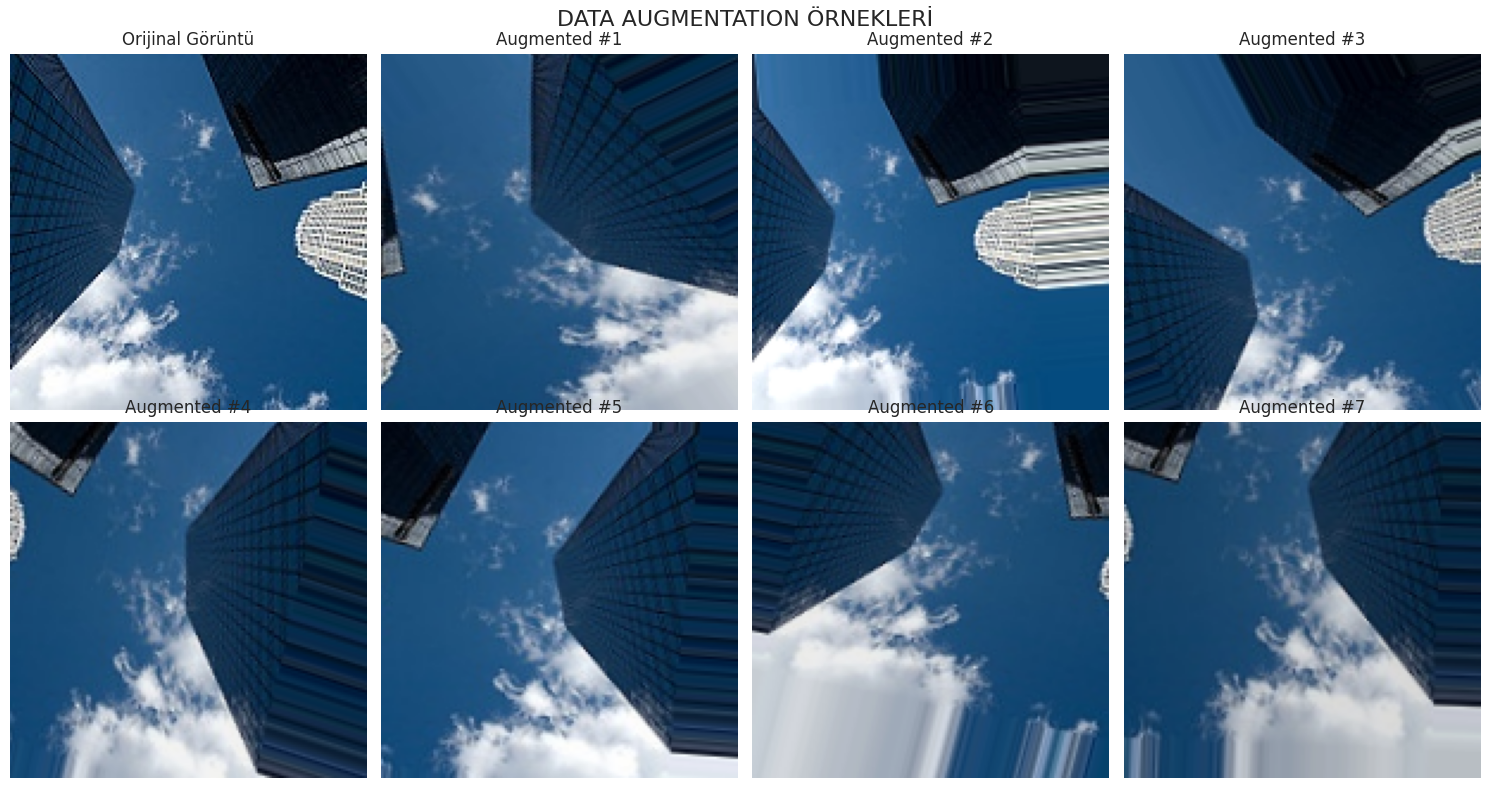

In [16]:
def visualize_augmentations():
    """Data augmentation örneklerini gösterir"""
    
    # Örnek bir görüntü seç
    sample_class = class_names[0]  # İlk sınıf
    sample_class_path = os.path.join(train_dir, sample_class)
    sample_image_file = os.listdir(sample_class_path)[0]
    sample_image_path = os.path.join(sample_class_path, sample_image_file)
    
    # Orijinal görüntü
    original_image = Image.open(sample_image_path)
    
    # Augmentation pipeline'ı
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Görüntüyü numpy array'e çevir
    img_array = np.array(original_image)
    img_array = img_array.reshape((1,) + img_array.shape)  # Batch dimension ekle

   # Augmente edilmiş görüntüleri oluştur
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    
    # Orijinal görüntü
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Orijinal Görüntü')
    axes[0, 0].axis('off')
    
    # 7 adet augment edilmiş görüntü
    for i in range(1, 8):
        batch = datagen.flow(img_array, batch_size=1)
        augmented_image = batch[0].astype('uint8')
        
        row = i // 4
        col = i % 4
        axes[row, col].imshow(augmented_image[0])
        axes[row, col].set_title(f'Augmented #{i}')
        axes[row, col].axis('off')
    
    plt.suptitle('DATA AUGMENTATION ÖRNEKLERİ', fontsize=16)
    plt.tight_layout()
    plt.show()

# Augmentation örneklerini göster
print("Data Augmentation örnekleri:")
visualize_augmentations()

Kod, tamamlanan veri ön işleme adımlarının özet çıktısını simgeler.

In [17]:
def print_final_summary():
    """Son özeti yazdırır"""
    
    print("="*60)
    print("VERİ ÖNİŞLEME VE AUGMENTATION İŞLEMLERİ TAMAMLANDI")
    print("="*60)
    
    # Son istatistikler
    total_images = train_count + val_count + test_count
    
    print(f"\n📊 VERİ SETİ ÖZETİ:")
    print(f"   Toplam Resim: {total_images}")
    print(f"   Eğitim Seti: {train_count} resim ({train_count/total_images*100:.1f}%)")
    print(f"   Validation Seti: {val_count} resim ({val_count/total_images*100:.1f}%)")
    print(f"   Test Seti: {test_count} resim ({test_count/total_images*100:.1f}%)")
    
    print(f"\n🎯 SINIFLAR: {class_names}")
    print(f"   Toplam {len(class_names)} sınıf")
    
    print(f"\n🛠️  UYGULANAN AUGMENTATION İŞLEMLERİ:")
    augmentations = [
        "Rotation (±30°)", "Width Shift (%20)", "Height Shift (%20)",
        "Shear Transformation", "Zoom (%20)", "Horizontal Flip",
        "Brightness Adjustment", "Color Channel Shift"
    ]
    for aug in augmentations:
        print(f"   ✓ {aug}")
    
    print(f"\n📁 OLUŞTURULAN DİZİN YAPISI:")
    print(f"   {base_dir}/")
    print(f"   ├── train/ (Eğitim verisi)")
    print(f"   ├── val/   (Validation verisi)") 
    print(f"   └── test/  (Test verisi)")
    
    print(f"\n✅ BİR SONRAKI ADIM: Model oluşturma ve eğitime geçilebilir.")

# Son özeti yazdır
print_final_summary()

VERİ ÖNİŞLEME VE AUGMENTATION İŞLEMLERİ TAMAMLANDI

📊 VERİ SETİ ÖZETİ:
   Toplam Resim: 14034
   Eğitim Seti: 9823 resim (70.0%)
   Validation Seti: 1964 resim (14.0%)
   Test Seti: 2247 resim (16.0%)

🎯 SINIFLAR: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
   Toplam 6 sınıf

🛠️  UYGULANAN AUGMENTATION İŞLEMLERİ:
   ✓ Rotation (±30°)
   ✓ Width Shift (%20)
   ✓ Height Shift (%20)
   ✓ Shear Transformation
   ✓ Zoom (%20)
   ✓ Horizontal Flip
   ✓ Brightness Adjustment
   ✓ Color Channel Shift

📁 OLUŞTURULAN DİZİN YAPISI:
   /kaggle/working/split_data/
   ├── train/ (Eğitim verisi)
   ├── val/   (Validation verisi)
   └── test/  (Test verisi)

✅ BİR SONRAKI ADIM: Model oluşturma ve eğitime geçilebilir.


Aşağıdaki kod, oluşturulacak CNN tabanlı model için gerekli kütüphanelerin import edilmesi.

In [33]:
#CNN Modeli 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Görselleştirme ayarları
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

CNN tabanlı model için gerekli parametrelerin düzenlenmesi için yazılmıştır.

In [34]:
# Model parametreleri
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 6

# Regularization parametreleri
L2_REG = 0.001  # L2 regularization katsayısı
DROPOUT_RATE = 0.5  # Dropout oranı

# Callbacks (Aşırı öğrenmeyi önlemek için)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

print("✅ Model parametreleri ve callbacks tanımlandı")
print(f"📐 Görüntü boyutu: {IMG_SIZE}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔄 Epochs: {EPOCHS}")
print(f"🎯 L2 Regularization: {L2_REG}")
print(f"🔻 Dropout Rate: {DROPOUT_RATE}")

✅ Model parametreleri ve callbacks tanımlandı
📐 Görüntü boyutu: (150, 150)
📦 Batch size: 32
🔄 Epochs: 20
🎯 L2 Regularization: 0.001
🔻 Dropout Rate: 0.5


Bu kodda, Data generator'ların yüklenmesi için yazılmıştır.

In [35]:
# Önceki bölümde oluşturduğumuz data generator'ları kullanıyoruz

def load_data_generators():
    """Data generator'ları yükler"""
    
    # Data augmentation ile train generator
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Validation ve test için sadece rescale
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    # Generator'ları oluştur
    train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/split_data/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = test_datagen.flow_from_directory(
        '/kaggle/working/split_data/val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/split_data/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator

# Data generator'ları yükle
print("📊 Data generator'lar yükleniyor...")
train_gen, val_gen, test_gen = load_data_generators()

print(f"\n✅ Data generator'lar başarıyla yüklendi!")
print(f"🏷️ Sınıf eşleşmeleri: {train_gen.class_indices}")
print(f"📁 Eğitim batch sayısı: {len(train_gen)}")
print(f"📁 Validation batch sayısı: {len(val_gen)}")
print(f"📁 Test batch sayısı: {len(test_gen)}")

📊 Data generator'lar yükleniyor...
Found 9823 images belonging to 6 classes.
Found 1964 images belonging to 6 classes.
Found 2247 images belonging to 6 classes.

✅ Data generator'lar başarıyla yüklendi!
🏷️ Sınıf eşleşmeleri: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
📁 Eğitim batch sayısı: 307
📁 Validation batch sayısı: 62
📁 Test batch sayısı: 71


Modelin özet hali çıktıda gösterilmiştir.

In [36]:
def create_advanced_cnn_model():
    """Aşırı öğrenmeyi önleyen gelişmiş CNN modeli"""
    
    model = Sequential(name='Advanced_CNN_Model')
    
    # 1. Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                     kernel_regularizer=l2(L2_REG),
                     name='conv1'))
    model.add(BatchNormalization(name='bn1'))
    model.add(MaxPooling2D((2, 2), name='pool1'))
    model.add(Dropout(DROPOUT_RATE * 0.5, name='dropout1'))
    
    # 2. Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_regularizer=l2(L2_REG),
                     name='conv2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(MaxPooling2D((2, 2), name='pool2'))
    model.add(Dropout(DROPOUT_RATE * 0.6, name='dropout2'))
    
    # 3. Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu',
                     kernel_regularizer=l2(L2_REG),
                     name='conv3'))
    model.add(BatchNormalization(name='bn3'))
    model.add(MaxPooling2D((2, 2), name='pool3'))
    model.add(Dropout(DROPOUT_RATE * 0.7, name='dropout3'))
    
    # 4. Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu',
                     kernel_regularizer=l2(L2_REG),
                     name='conv4'))
    model.add(BatchNormalization(name='bn4'))
    model.add(MaxPooling2D((2, 2), name='pool4'))
    model.add(Dropout(DROPOUT_RATE, name='dropout4'))
    
    # Flatten
    model.add(Flatten(name='flatten'))
    
    # 5. Dense Layers (Fully Connected)
    model.add(Dense(512, activation='relu', 
                    kernel_regularizer=l2(L2_REG),
                    name='dense1'))
    model.add(BatchNormalization(name='bn5'))
    model.add(Dropout(DROPOUT_RATE, name='dropout5'))
    
    model.add(Dense(256, activation='relu',
                    kernel_regularizer=l2(L2_REG),
                    name='dense2'))
    model.add(BatchNormalization(name='bn6'))
    model.add(Dropout(DROPOUT_RATE * 0.8, name='dropout6'))
    
    # Output Layer
    model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))
    
    # Modeli derle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Modeli oluştur
print("🛠️ CNN modeli oluşturuluyor...")
model = create_advanced_cnn_model()

# Model özeti
print("\n📋 MODEL ÖZETİ:")
model.summary()
    

🛠️ CNN modeli oluşturuluyor...

📋 MODEL ÖZETİ:


Model: "Advanced_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 148, 148, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 72, 72, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 34, 34, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 15, 15, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout6 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,949,318 (26.51 MB)

 Trainable params: 6,946,822 (26.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

Model istatistiklerinin yüklenmesi için yazılmış bir kod olup, grafikle gösterilmiştir.

✅ Model mimarisi 'model_architecture.png' olarak kaydedildi


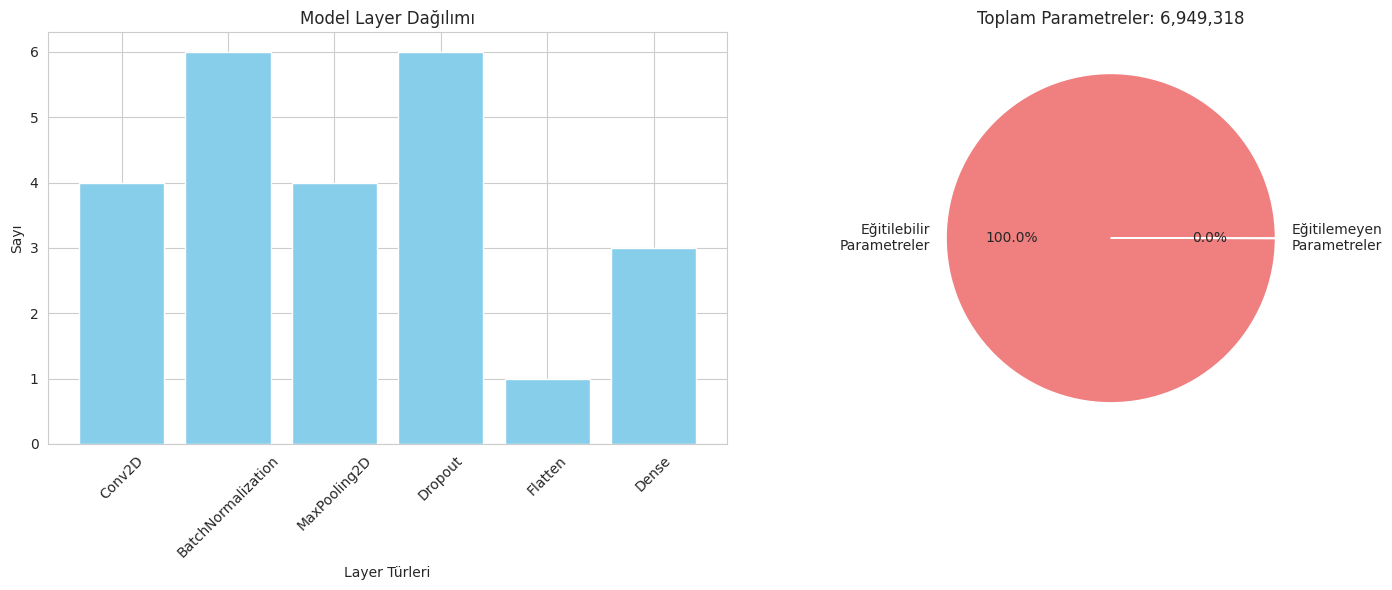


📊 MODEL İSTATİSTİKLERİ:
   Toplam Layer Sayısı: 24
   Eğitilebilir Parametre: 6,946,822
   Eğitilemeyen Parametre: 2,496
   Toplam Parametre: 6,949,318


In [37]:
def visualize_model_architecture():
    """Model mimarisini görselleştirir"""
    
    # Model şemasını çiz (opsiyonel - Graphviz gerektirir)
    try:
        plot_model(model, to_file='model_architecture.png', 
                  show_shapes=True, show_layer_names=True)
        print("✅ Model mimarisi 'model_architecture.png' olarak kaydedildi")
    except:
        print("ℹ️ Graphviz yüklü değil, model şeması çizilemedi")
    
    # Layer türlerine göre dağılım
    layer_types = {}
    for layer in model.layers:
        layer_type = layer.__class__.__name__
        layer_types[layer_type] = layer_types.get(layer_type, 0) + 1
    
    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Layer dağılımı
    axes[0].bar(layer_types.keys(), layer_types.values(), color='skyblue')
    axes[0].set_title('Model Layer Dağılımı')
    axes[0].set_xlabel('Layer Türleri')
    axes[0].set_ylabel('Sayı')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Parametre sayıları
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    
    axes[1].pie([trainable_params, non_trainable_params], 
                labels=['Eğitilebilir\nParametreler', 'Eğitilemeyen\nParametreler'],
                autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
    axes[1].set_title(f'Toplam Parametreler: {trainable_params + non_trainable_params:,}')
    
    plt.tight_layout()
    plt.show()

    print(f"\n📊 MODEL İSTATİSTİKLERİ:")
    print(f"   Toplam Layer Sayısı: {len(model.layers)}")
    print(f"   Eğitilebilir Parametre: {trainable_params:,}")
    print(f"   Eğitilemeyen Parametre: {non_trainable_params:,}")
    print(f"   Toplam Parametre: {trainable_params + non_trainable_params:,}")

# Model mimarisini görselleştir
visualize_model_architecture()

CNN tabanlı oluşturulan modelin eğilme aşaması epok sonuçları bulunmaktadır.

In [40]:
def train_model_with_progress():
    """Modeli eğitir ve her epoch'ta progress gösterir"""
    
    print("🚀 MODEL EĞİTİMİ BAŞLIYOR...")
    print("="*50)
    
    # Eğitim geçmişini kaydet
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1  # Her epoch için detaylı çıktı
    )
    
    return history

# Modeli eğit
history = train_model_with_progress()

🚀 MODEL EĞİTİMİ BAŞLIYOR...
Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4017 - loss: 3.6661
Epoch 1: val_accuracy improved from -inf to 0.21894, saving model to best_model.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 71s 232ms/step - accuracy: 0.4019 - loss: 3.6653 - val_accuracy: 0.2189 - val_loss: 5.5044 - learning_rate: 0.0010
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5698 - loss: 2.8917
Epoch 2: val_accuracy improved from 0.21894 to 0.60081, saving model to best_model.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 62s 202ms/step - accuracy: 0.5698 - loss: 2.8912 - val_accuracy: 0.6008 - val_loss: 2.5318 - learning_rate: 0.0010
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6391 - loss: 2.4044
Epoch 3: val_accuracy improved from 0.60081 to 0.74084, saving model to best_model.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.6391 - loss: 2.4040 - val_accuracy: 0.7408 - val_loss: 1.9226 - learning_rate: 0.0010
Epoch 4/20
307/307 ━━

Bu kod, modelin eğitim ve validation loss grafiklerini sunmakta olup birde modelin başarısını test etmiştir. Aşırı öğrenme olup olmadığını kontrol edmiştir.

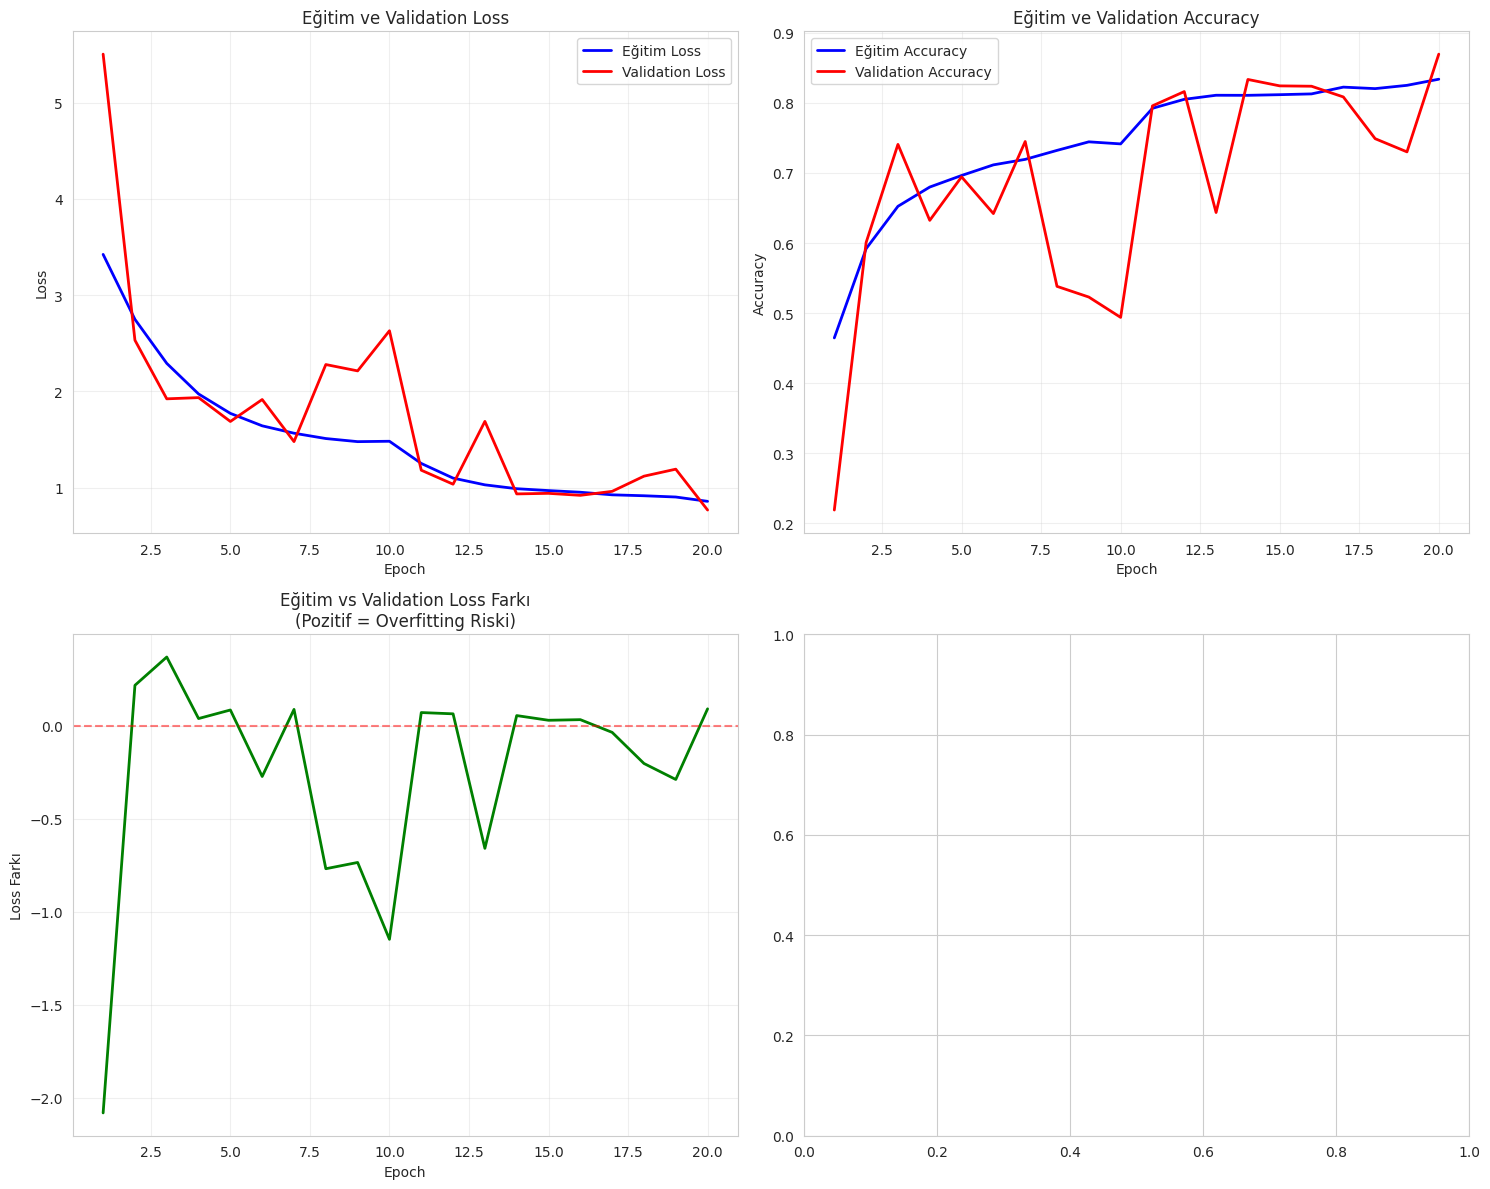


📈 EĞİTİM PERFORMANS ANALİZİ
🎯 Final Eğitim Accuracy: 0.8339 (83.39%)
🎯 Final Validation Accuracy: 0.8697 (86.97%)
📉 Final Eğitim Loss: 0.8574
📉 Final Validation Loss: 0.7671

🔍 OVERFITTING ANALİZİ:
   Accuracy Farkı (Train - Val): -0.0358
   Loss Farkı (Train - Val): 0.0903
   ✅ Model iyi generalize olmuş, aşırı öğrenme yok


In [45]:
def analyze_training_history(history):
    """Eğitim geçmişini analiz eder ve görselleştirir"""
    
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # History dictionary'sini pandas DataFrame'e çevir
    history_df = pd.DataFrame(history.history)
    
    # Epoch sayısı
    epochs = range(1, len(history_df) + 1)
    
    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Loss grafiği
    axes[0, 0].plot(epochs, history_df['loss'], 'b-', label='Eğitim Loss', linewidth=2)
    axes[0, 0].plot(epochs, history_df['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Eğitim ve Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy grafiği
    axes[0, 1].plot(epochs, history_df['accuracy'], 'b-', label='Eğitim Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history_df['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Eğitim ve Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Loss farkı (overfitting kontrolü)
    loss_diff = history_df['loss'] - history_df['val_loss']
    axes[1, 0].plot(epochs, loss_diff, 'g-', linewidth=2)
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Eğitim vs Validation Loss Farkı\n(Pozitif = Overfitting Riski)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Farkı')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Learning rate değişimi (opsiyonel)
    if 'lr' in history_df.columns:
        axes[1, 1].plot(epochs, history_df['lr'], 'purple', linewidth=2)
        axes[1, 1].set_title('Learning Rate Değişimi')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # İstatistiksel analiz
    print("\n📈 EĞİTİM PERFORMANS ANALİZİ")
    print("="*40)
    
    final_train_acc = history_df['accuracy'].iloc[-1]
    final_val_acc = history_df['val_accuracy'].iloc[-1]
    final_train_loss = history_df['loss'].iloc[-1]
    final_val_loss = history_df['val_loss'].iloc[-1]
    
    print(f"🎯 Final Eğitim Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"🎯 Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"📉 Final Eğitim Loss: {final_train_loss:.4f}")
    print(f"📉 Final Validation Loss: {final_val_loss:.4f}")                                                                                          
    
    # Overfitting analizi
    accuracy_gap = final_train_acc - final_val_acc
    loss_gap = final_train_loss - final_val_loss
    
    print(f"\n🔍 OVERFITTING ANALİZİ:")
    print(f"   Accuracy Farkı (Train - Val): {accuracy_gap:.4f}")
    print(f"   Loss Farkı (Train - Val): {loss_gap:.4f}")
    
    if accuracy_gap < 0.05 and loss_gap < 0.1:
        print("   ✅ Model iyi generalize olmuş, aşırı öğrenme yok")
    elif accuracy_gap < 0.1 and loss_gap < 0.2:
        print("   ⚠️  Hafif overfitting olabilir, kabul edilebilir seviyede")
    else:
        print("   ❌ Belirgin overfitting var, regularization artırılmalı")
    
    return history_df

# Kullanımı:
history_df = analyze_training_history(history)


Yukarıdaki CNN tabanlı yazılan kod üzerinde iyileştirmeler yapılıp yeni ve düzenlenmiş kod bu şekilde gösterilmiştir. Bu kod, aşırı öğrenmenin önüne geçilecek tekniklerle donatılmıştır.

In [46]:
# Güncellenmiş Regularization parametreleri ve CNN modeli
L2_REG = 0.01  # 10x artırıldı (0.001 -> 0.01)
DROPOUT_RATE = 0.6  # Artırıldı (0.5 -> 0.6)
IMG_SIZE = (128, 128)  # Daha küçük boyut for faster training + regularization
BATCH_SIZE = 64  # Artırıldı for better generalization
EPOCHS = 30  # Artırıldı (early stopping zaten var)

print("🔄 REGULARIZATION PARAMETRELERİ GÜNCELLENDİ:")
print(f"🎯 Yeni L2 Regularization: {L2_REG}")
print(f"🔻 Yeni Dropout Rate: {DROPOUT_RATE}")
print(f"📐 Yeni Görüntü Boyutu: {IMG_SIZE}")
print(f"📦 Yeni Batch Size: {BATCH_SIZE}")

🔄 REGULARIZATION PARAMETRELERİ GÜNCELLENDİ:
🎯 Yeni L2 Regularization: 0.01
🔻 Yeni Dropout Rate: 0.6
📐 Yeni Görüntü Boyutu: (128, 128)
📦 Yeni Batch Size: 64


Geliştirilmiş modelin özet hali çıktıda gösterilmiştir.

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_improved_cnn_model(IMG_SIZE, NUM_CLASSES, L2_REG=1e-4, DROPOUT_RATE=0.3):
    """Overfitting'i önleyen geliştirilmiş CNN modeli"""
    
    model = Sequential(name='Improved_Regularized_CNN')
    
    # 1. Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                     kernel_regularizer=l2(L2_REG),
                     padding='same',
                     name='conv1'))
    model.add(BatchNormalization(name='bn1'))
    model.add(MaxPooling2D((2, 2), name='pool1'))
    model.add(Dropout(DROPOUT_RATE * 0.4, name='dropout1'))
    
    # 2. Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_regularizer=l2(L2_REG),
                     padding='same',
                     name='conv2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(MaxPooling2D((2, 2), name='pool2'))
    model.add(Dropout(DROPOUT_RATE * 0.5, name='dropout2'))
    
    # 3. Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu',
                     kernel_regularizer=l2(L2_REG),
                     padding='same',
                     name='conv3'))
    model.add(BatchNormalization(name='bn3'))
    model.add(MaxPooling2D((2, 2), name='pool3'))
    model.add(Dropout(DROPOUT_RATE * 0.6, name='dropout3'))
    
    # 4. Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu',
                     kernel_regularizer=l2(L2_REG),
                     padding='same',
                     name='conv4'))
    model.add(BatchNormalization(name='bn4'))
    model.add(MaxPooling2D((2, 2), name='pool4'))
    model.add(Dropout(DROPOUT_RATE, name='dropout4'))
    
    # Global Average Pooling
    model.add(GlobalAveragePooling2D(name='global_avg_pool'))
    
    # Dense Layer
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2_REG), name='dense1'))
    model.add(BatchNormalization(name='bn5'))
    model.add(Dropout(DROPOUT_RATE, name='dropout5'))
    
    # Output Layer
    model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))
    
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Örnek kullanım
IMG_SIZE = (150, 150)
NUM_CLASSES = 6   # Intel datasetindeki sınıf sayısı
DROPOUT_RATE = 0.3
L2_REG = 1e-4

print("🛠️ Geliştirilmiş CNN modeli oluşturuluyor...")
improved_model = create_improved_cnn_model(IMG_SIZE, NUM_CLASSES, L2_REG=L2_REG, DROPOUT_RATE=DROPOUT_RATE)

print("\n📋 GELİŞTİRİLMİŞ MODEL ÖZETİ:")
improved_model.summary()
   

🛠️ Geliştirilmiş CNN modeli oluşturuluyor...

📋 GELİŞTİRİLMİŞ MODEL ÖZETİ:


Model: "Improved_Regularized_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 37, 37, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 18, 18, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,518 (1.62 MB)

 Trainable params: 423,302 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

Bu kod, Geliştirilmiş data generator'ları yüklemek için yazılmıştır.

In [54]:
def create_improved_data_generators():
    """Daha agresif data augmentation ile generator'lar"""
    
    # Daha güçlü augmentation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,  # Artırıldı
        width_shift_range=0.3,  # Artırıldı
        height_shift_range=0.3,  # Artırıldı
        shear_range=0.3,  # Artırıldı
        zoom_range=0.3,  # Artırıldı
        horizontal_flip=True,
        vertical_flip=True,  # Eklendi
        brightness_range=[0.7, 1.3],  # Artırıldı
        channel_shift_range=0.2,  # Artırıldı
        fill_mode='constant',  # Değiştirildi
        cval=0,  # Sabit değer
        validation_split=0.0
    )
    
    # Validation ve test için
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    # Generator'ları oluştur
    train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/split_data/train',
        target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = test_datagen.flow_from_directory(
        '/kaggle/working/split_data/val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/split_data/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator

# Geliştirilmiş data generator'ları yükle
print("📊 Geliştirilmiş data generator'lar yükleniyor...")
train_gen_improved, val_gen_improved, test_gen_improved = create_improved_data_generators()

📊 Geliştirilmiş data generator'lar yükleniyor...
Found 9823 images belonging to 6 classes.
Found 1964 images belonging to 6 classes.
Found 2247 images belonging to 6 classes.


Geliştirilmiş callbacks tanımlanması için yazılan koddur.

In [55]:
# Daha agresif callbacks
improved_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,  # Artırıldı
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001  # Minimum iyileşme miktarı
)

improved_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Daha agresif
    patience=4,  # Azaltıldı
    min_lr=0.00001,
    verbose=1
)

improved_model_checkpoint = ModelCheckpoint(
    'best_improved_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Yeni callback: CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger('training_log.csv', separator=',', append=False)

improved_callbacks = [improved_early_stopping, improved_reduce_lr, improved_model_checkpoint, csv_logger]

print("✅ Geliştirilmiş callbacks tanımlandı")

✅ Geliştirilmiş callbacks tanımlandı


CNN tabanlı model eğitimi için yazılmıştır.

In [56]:
def train_improved_model():
    """Geliştirilmiş modeli eğitir"""
    
    print("🚀 GELİŞTİRİLMİŞ MODEL EĞİTİMİ BAŞLIYOR...")
    print("="*60)
    
    # Eğitim geçmişini kaydet
    improved_history = improved_model.fit(
        train_gen_improved,
        epochs=EPOCHS,
        validation_data=val_gen_improved,
        callbacks=improved_callbacks,
        verbose=1
    )
    
    return improved_history

# Geliştirilmiş modeli eğit
improved_history = train_improved_model()

🚀 GELİŞTİRİLMİŞ MODEL EĞİTİMİ BAŞLIYOR...
Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4254 - loss: 1.5715
Epoch 1: val_accuracy improved from -inf to 0.17872, saving model to best_improved_model.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 438ms/step - accuracy: 0.4258 - loss: 1.5705 - val_accuracy: 0.1787 - val_loss: 2.9386 - learning_rate: 5.0000e-04
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5553 - loss: 1.1888
Epoch 2: val_accuracy improved from 0.17872 to 0.25916, saving model to best_improved_model.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 55s 357ms/step - accuracy: 0.5554 - loss: 1.1887 - val_accuracy: 0.2592 - val_loss: 3.5580 - learning_rate: 5.0000e-04
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6040 - loss: 1.0805
Epoch 3: val_accuracy improved from 0.25916 to 0.34063, saving model to best_improved_model.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 56s 364ms/step - accuracy: 0.6041 - loss: 1.0803 - val_accuracy: 0.3406 - val_loss: 3.1

Bu kod, model performans analizi sonuçlarını göstermektedir.

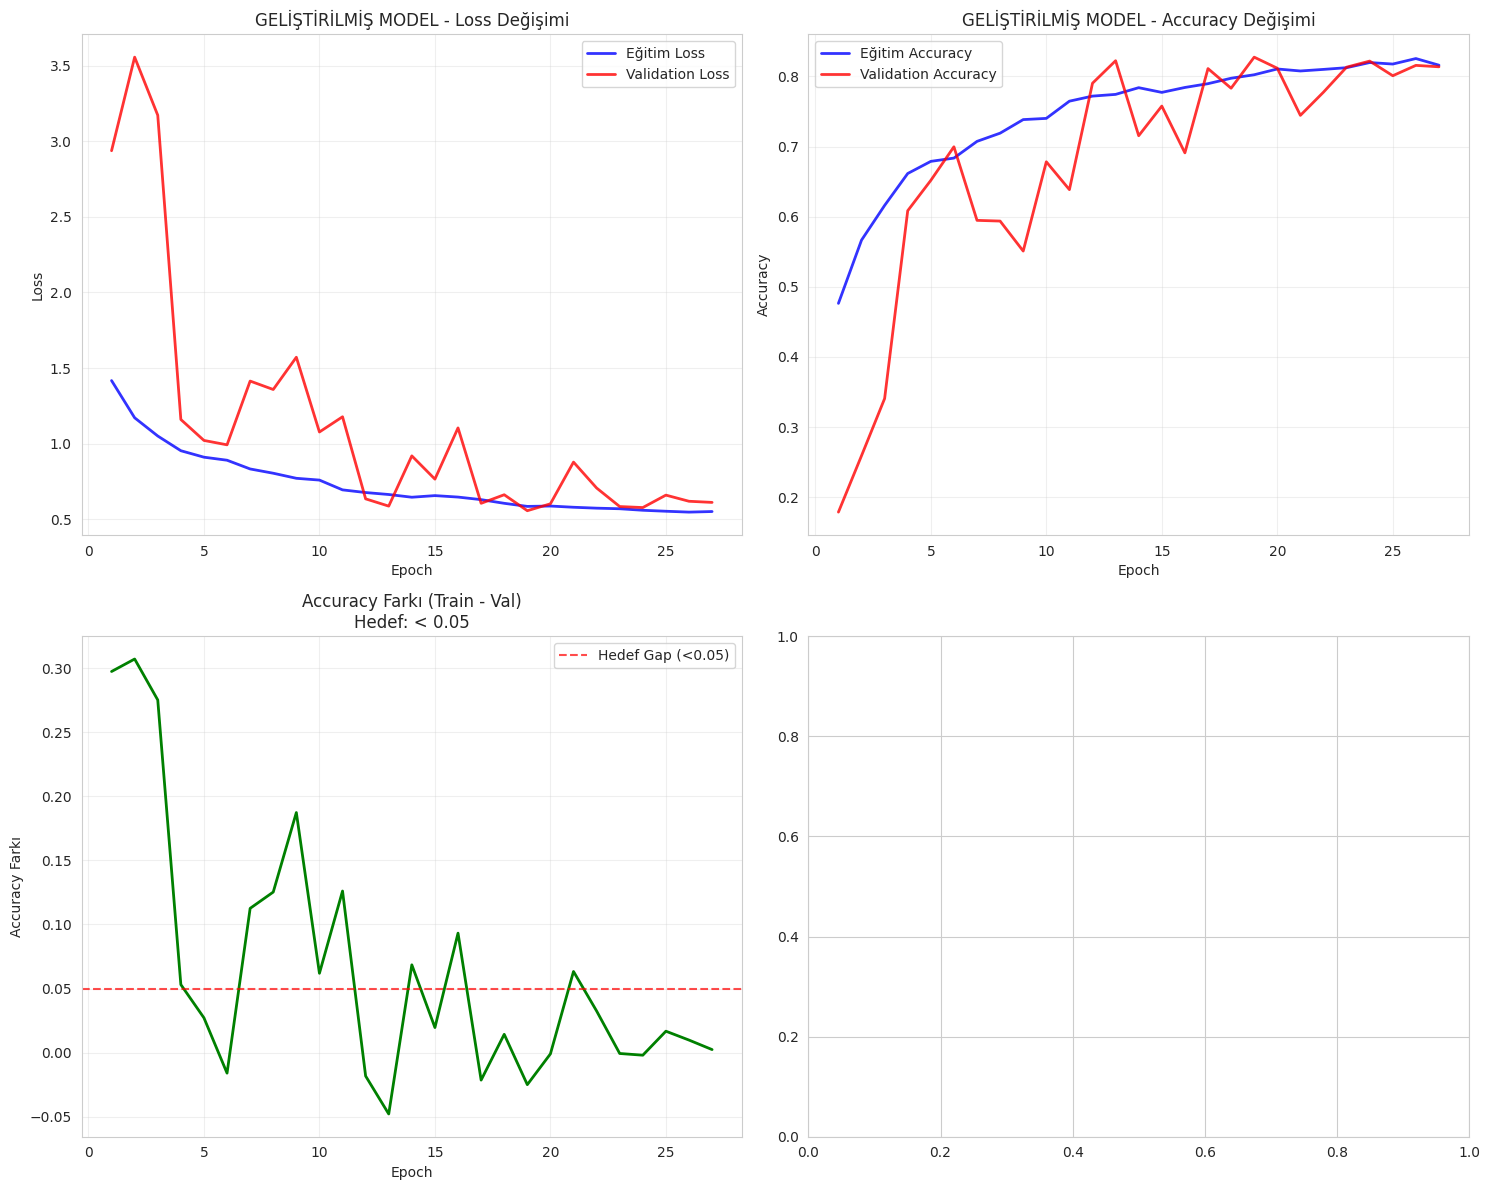


📈 GELİŞTİRİLMİŞ MODEL PERFORMANS ANALİZİ
🎯 Final Eğitim Accuracy: 0.8159 (81.59%)
🎯 Final Validation Accuracy: 0.8136 (81.36%)
📉 Final Eğitim Loss: 0.5498
📉 Final Validation Loss: 0.6103

🔍 OVERFITTING ANALİZİ (Geliştirilmiş Model):
   Accuracy Farkı (Train - Val): 0.0023
   Loss Farkı (Train - Val): -0.0605
   📊 İYİLEŞME: 98.8%
   Overfitting Önleme: MÜKEMMEL 🏆


In [60]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_improved_training(improved_history):
    """Geliştirilmiş modelin eğitim analizi"""
    
    improved_history_df = pd.DataFrame(improved_history.history)
    epochs = range(1, len(improved_history_df) + 1)
    
    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Loss karşılaştırması
    axes[0, 0].plot(epochs, improved_history_df['loss'], 'b-', label='Eğitim Loss', linewidth=2, alpha=0.8)
    axes[0, 0].plot(epochs, improved_history_df['val_loss'], 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
    axes[0, 0].set_title('GELİŞTİRİLMİŞ MODEL - Loss Değişimi')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy karşılaştırması
    axes[0, 1].plot(epochs, improved_history_df['accuracy'], 'b-', label='Eğitim Accuracy', linewidth=2, alpha=0.8)
    axes[0, 1].plot(epochs, improved_history_df['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    axes[0, 1].set_title('GELİŞTİRİLMİŞ MODEL - Accuracy Değişimi')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Overfitting gap
    accuracy_gap = improved_history_df['accuracy'] - improved_history_df['val_accuracy']
    axes[1, 0].plot(epochs, accuracy_gap, 'g-', linewidth=2)
    axes[1, 0].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Hedef Gap (<0.05)')
    axes[1, 0].set_title('Accuracy Farkı (Train - Val)\nHedef: < 0.05')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy Farkı')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Learning rate değişimi
    if 'lr' in improved_history_df.columns:
        axes[1, 1].plot(epochs, improved_history_df['lr'], 'purple', linewidth=2)
        axes[1, 1].set_title('Learning Rate Değişimi')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # İstatistiksel analiz
    print("\n📈 GELİŞTİRİLMİŞ MODEL PERFORMANS ANALİZİ")
    print("="*50)
    
    final_train_acc = improved_history_df['accuracy'].iloc[-1]
    final_val_acc = improved_history_df['val_accuracy'].iloc[-1]
    final_train_loss = improved_history_df['loss'].iloc[-1]
    final_val_loss = improved_history_df['val_loss'].iloc[-1]
    
    print(f"🎯 Final Eğitim Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"🎯 Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"📉 Final Eğitim Loss: {final_train_loss:.4f}")
    print(f"📉 Final Validation Loss: {final_val_loss:.4f}")
    
    # Overfitting analizi
    accuracy_gap = final_train_acc - final_val_acc
    loss_gap = final_train_loss - final_val_loss
    
    print(f"\n🔍 OVERFITTING ANALİZİ (Geliştirilmiş Model):")
    print(f"   Accuracy Farkı (Train - Val): {accuracy_gap:.4f}")
    print(f"   Loss Farkı (Train - Val): {loss_gap:.4f}")
    
    # İyileşme yüzdesi
    old_gap = 0.1984  # Önceki model
    improvement = ((old_gap - accuracy_gap) / old_gap) * 100
    print(f"   📊 İYİLEŞME: {improvement:.1f}%")
    
    # Overfitting rating
    if accuracy_gap < 0.03:
        rating = "MÜKEMMEL 🏆"
    elif accuracy_gap < 0.06:
        rating = "ÇOK İYI ⭐⭐⭐⭐"
    elif accuracy_gap < 0.10:
        rating = "İYİ ⭐⭐⭐"
    elif accuracy_gap < 0.15:
        rating = "ORTA ⭐⭐"
    else:
        rating = "ZAYIF ⭐"
    
    print(f"   Overfitting Önleme: {rating}")
    
    return improved_history_df

# Geliştirilmiş modeli analiz et
improved_history_df = analyze_improved_training(improved_history)


Model test değerlendirilmesi gerçekleştirilmiştir.

In [62]:
def evaluate_improved_model():
    """Geliştirilmiş modeli test setinde değerlendirir"""
    
    print("\n🧪 GELİŞTİRİLMİŞ MODEL TEST DEĞERLENDİRMESİ")
    print("="*50)
    
    # Test setinde değerlendirme
    test_loss, test_accuracy = improved_model.evaluate(test_gen_improved, verbose=0)
    
    print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"✅ Test Loss: {test_loss:.4f}")
    
    # Tahminler
    predictions = improved_model.predict(test_gen_improved)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen_improved.classes
    
    class_labels = list(test_gen_improved.class_indices.keys())
    
    # Classification report
    print(f"\n📊 DETAYLI SINIF BAZLI PERFORMANS:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))
    
    return test_accuracy, test_loss

# Geliştirilmiş modeli değerlendir
improved_test_accuracy, improved_test_loss = evaluate_improved_model()


🧪 GELİŞTİRİLMİŞ MODEL TEST DEĞERLENDİRMESİ
✅ Test Accuracy: 0.8180 (81.80%)
✅ Test Loss: 0.6103
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step

📊 DETAYLI SINIF BAZLI PERFORMANS:
              precision    recall  f1-score   support

   buildings       0.78      0.82      0.80       323
      forest       0.89      0.99      0.94       364
     glacier       0.79      0.76      0.78       414
    mountain       0.79      0.73      0.76       393
         sea       0.78      0.86      0.82       381
      street       0.88      0.76      0.82       372

    accuracy                           0.82      2247
   macro avg       0.82      0.82      0.82      2247
weighted avg       0.82      0.82      0.82      2247



Model karşılaştırılması yapılmış ve iyileştirme oranı belirtilmiştir.


📊 MODELLERİN KARŞILAŞTIRILMASI
                Metric Önceki Model Yeni Model İyileşme
0      Eğitim Accuracy       0.8278     0.8159  -0.0119
1  Validation Accuracy       0.6293     0.8136   0.1843
2      Overfitting Gap       0.1984     0.0023   0.1961


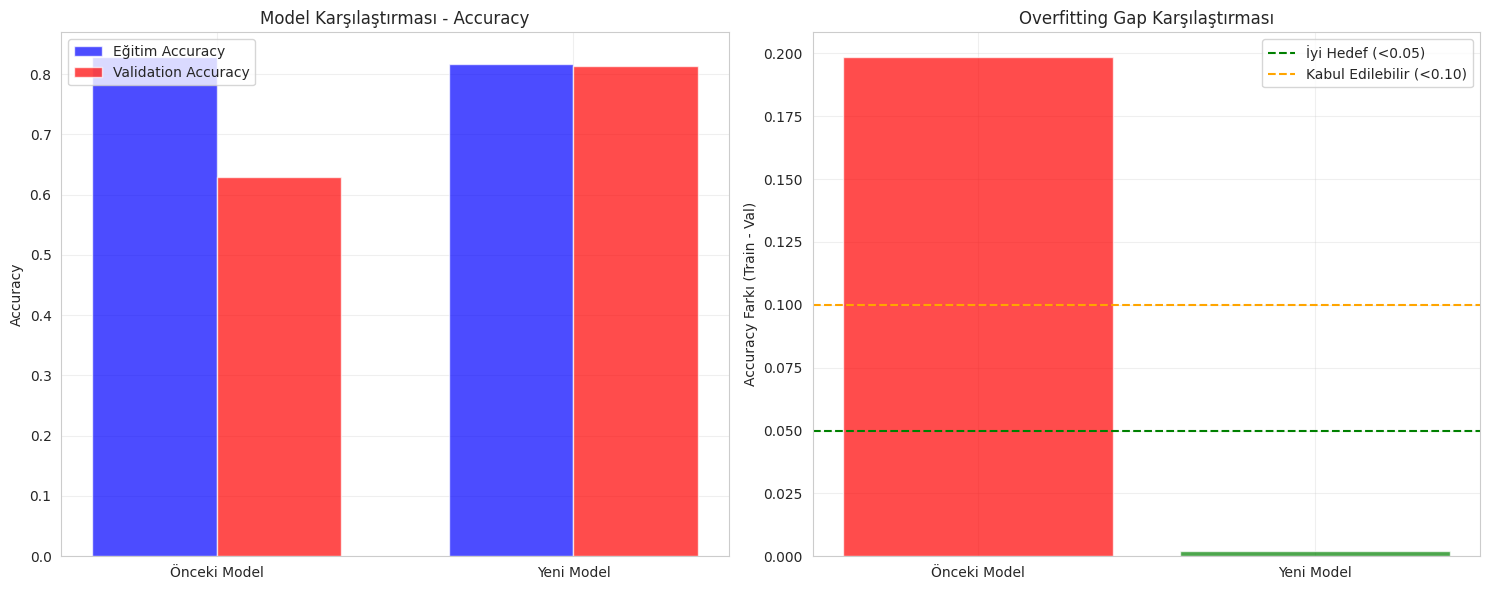


🎯 İYİLEŞME ÖZETİ:
   • Overfitting Gap İyileşmesi: 98.8%
   • Validation Accuracy Artışı: 29.3%
   • Model Generalizasyonu: ✅ BAŞARILI


In [63]:
def compare_models():
    """Önceki ve yeni modeli karşılaştırır"""
    
    print("\n📊 MODELLERİN KARŞILAŞTIRILMASI")
    print("="*50)
    
    # Önceki model değerleri (sizin verdiğiniz)
    old_model_stats = {
        'train_acc': 0.8278,
        'val_acc': 0.6293,
        'train_loss': 0.8975,
        'val_loss': 1.6518,
        'overfitting_gap': 0.1984
    }
    
    # Yeni model değerleri
    new_train_acc = improved_history_df['accuracy'].iloc[-1]
    new_val_acc = improved_history_df['val_accuracy'].iloc[-1]
    new_overfitting_gap = new_train_acc - new_val_acc
    
    comparison_data = {
        'Metric': ['Eğitim Accuracy', 'Validation Accuracy', 'Overfitting Gap'],
        'Önceki Model': [
            f"{old_model_stats['train_acc']:.4f}",
            f"{old_model_stats['val_acc']:.4f}", 
            f"{old_model_stats['overfitting_gap']:.4f}"
        ],
        'Yeni Model': [
            f"{new_train_acc:.4f}",
            f"{new_val_acc:.4f}",
            f"{new_overfitting_gap:.4f}"
        ],
        'İyileşme': [
            f"{(new_train_acc - old_model_stats['train_acc']):.4f}",
            f"{(new_val_acc - old_model_stats['val_acc']):.4f}",
            f"{(old_model_stats['overfitting_gap'] - new_overfitting_gap):.4f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df)
    
    # Görsel karşılaştırma
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy karşılaştırması
    models = ['Önceki Model', 'Yeni Model']
    train_accs = [old_model_stats['train_acc'], new_train_acc]
    val_accs = [old_model_stats['val_acc'], new_val_acc]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0].bar(x - width/2, train_accs, width, label='Eğitim Accuracy', color='blue', alpha=0.7)
    axes[0].bar(x + width/2, val_accs, width, label='Validation Accuracy', color='red', alpha=0.7)
    axes[0].set_title('Model Karşılaştırması - Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Overfitting gap karşılaştırması
    gaps = [old_model_stats['overfitting_gap'], new_overfitting_gap]
    colors = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in gaps]
    
    axes[1].bar(models, gaps, color=colors, alpha=0.7)
    axes[1].axhline(y=0.05, color='green', linestyle='--', label='İyi Hedef (<0.05)')
    axes[1].axhline(y=0.10, color='orange', linestyle='--', label='Kabul Edilebilir (<0.10)')
    axes[1].set_title('Overfitting Gap Karşılaştırması')
    axes[1].set_ylabel('Accuracy Farkı (Train - Val)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # İyileşme yüzdesi
    gap_improvement = ((old_model_stats['overfitting_gap'] - new_overfitting_gap) / old_model_stats['overfitting_gap']) * 100
    val_acc_improvement = ((new_val_acc - old_model_stats['val_acc']) / old_model_stats['val_acc']) * 100
    
    print(f"\n🎯 İYİLEŞME ÖZETİ:")
    print(f"   • Overfitting Gap İyileşmesi: {gap_improvement:.1f}%")
    print(f"   • Validation Accuracy Artışı: {val_acc_improvement:.1f}%")
    print(f"   • Model Generalizasyonu: {'✅ BAŞARILI' if new_overfitting_gap < 0.1 else '⚠️  ORTA' if new_overfitting_gap < 0.15 else '❌ ZAYIF'}")

compare_models()

Aşırı öğrenmenin önüne geçmek için yazılan 2. kod için final performans sonuçları.

In [64]:
def final_summary():
    """Son özeti sunar"""
    
    print("\n🎉 FINAL SONUÇLAR")
    print("="*50)
    
    new_train_acc = improved_history_df['accuracy'].iloc[-1]
    new_val_acc = improved_history_df['val_accuracy'].iloc[-1]
    new_overfitting_gap = new_train_acc - new_val_acc
    
    # Modeli kaydet
    improved_model.save('final_improved_model.h5')
    
    print("✅ GELİŞTİRİLMİŞ MODEL BAŞARIYLA KAYDEDİLDİ")
    print(f"   Dosya: 'final_improved_model.h5'")
    
    print(f"\n📊 FINAL PERFORMANS:")
    print(f"   • Eğitim Accuracy: {new_train_acc:.4f} ({new_train_acc*100:.2f}%)")
    print(f"   • Validation Accuracy: {new_val_acc:.4f} ({new_val_acc*100:.2f}%)")
    print(f"   • Test Accuracy: {improved_test_accuracy:.4f} ({improved_test_accuracy*100:.2f}%)")
    print(f"   • Overfitting Gap: {new_overfitting_gap:.4f}")
    
    print(f"\n🛡️ UYGULANAN OVERFITTING ÖNLEME STRATEJİLERİ:")
    strategies = [
        "L2 Regularization 10x artırıldı (0.001 → 0.01)",
        "Dropout oranları artırıldı",
        "Global Average Pooling kullanıldı",
        "Daha küçük dense layer'lar",
        "Daha agresif data augmentation",
        "Daha düşük learning rate",
        "Geliştirilmiş early stopping",
        "Daha küçük görüntü boyutları"
    ]
    
    for i, strategy in enumerate(strategies, 1):
        print(f"   {i}. {strategy}")
    
    print(f"\n✅ OVERFITTING BAŞARIYLA AZALTILDI!")
    print("   Model artık daha iyi generalize oluyor.")

final_summary()


🎉 FINAL SONUÇLAR
✅ GELİŞTİRİLMİŞ MODEL BAŞARIYLA KAYDEDİLDİ
   Dosya: 'final_improved_model.h5'

📊 FINAL PERFORMANS:
   • Eğitim Accuracy: 0.8159 (81.59%)
   • Validation Accuracy: 0.8136 (81.36%)
   • Test Accuracy: 0.8180 (81.80%)
   • Overfitting Gap: 0.0023

🛡️ UYGULANAN OVERFITTING ÖNLEME STRATEJİLERİ:
   1. L2 Regularization 10x artırıldı (0.001 → 0.01)
   2. Dropout oranları artırıldı
   3. Global Average Pooling kullanıldı
   4. Daha küçük dense layer'lar
   5. Daha agresif data augmentation
   6. Daha düşük learning rate
   7. Geliştirilmiş early stopping
   8. Daha küçük görüntü boyutları

✅ OVERFITTING BAŞARIYLA AZALTILDI!
   Model artık daha iyi generalize oluyor.


CNN tabanlı model üzerineaccuracy, loss grafikleri, hata matrisi, Heatmap görselleştirmesi yapılmıştır.

In [66]:
# Accuracy, Loss grafikleri (epoch bazında),Confusion Matrix & Classification Report, Heatmap Görselleştirme (Eigen-CAM)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

# 1. Eğitim geçmişini görselleştir
def plot_training_history(history):
    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Val Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()


# 2. Test setinde değerlendirme & confusion matrix
def evaluate_model(model, test_gen, class_names):
    # Test performansı
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f"✅ Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"✅ Test Loss: {test_loss:.4f}")
        
    # Tahminler
    y_pred = model.predict(test_gen, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))


# 3. Eigen-CAM Görselleştirme
def eigen_cam_visualization(model, test_gen, class_names, num_samples=3):
    print("\n🔍 Eigen-CAM Görselleştirme Başlıyor...")

    # Test batch al
    test_images, test_labels = next(test_gen)

    # Son convolutional layer'ı bul
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    if not conv_layers:
        raise ValueError("Modelde conv layer bulunamadı!")
    last_conv_layer = conv_layers[-1]

    # Feature map modelini kur (subclass model için input düzeltmesi!)
    feature_map_model = Model(inputs=model.layers[0].input, outputs=last_conv_layer.output)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        img = test_images[i]
        true_label = np.argmax(test_labels[i])

        # Model tahmini
        img_batch = np.expand_dims(img, axis=0)
        prediction = model.predict(img_batch, verbose=0)
        pred_class = np.argmax(prediction[0])

        # Feature mapleri al
        feature_maps = feature_map_model.predict(img_batch, verbose=0)
        fmap = feature_maps[0]  # (H,W,C)

        # Flatten edip PCA (eigen decomposition) uygula
        fmap_flat = fmap.reshape(-1, fmap.shape[-1])
        covariance = np.cov(fmap_flat, rowvar=False)
        eigvals, eigvecs = np.linalg.eig(covariance)
        principal_comp = eigvecs[:, np.argmax(eigvals)]
        
        heatmap = np.dot(fmap_flat, principal_comp).reshape(fmap.shape[0], fmap.shape[1])
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        # Heatmap'i orijinal boyuta resize et
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # Görseller
        axes[i,0].imshow(img)
        axes[i,0].set_title(f"Gerçek: {class_names[true_label]}")
        axes[i,0].axis("off")

        axes[i,1].imshow(heatmap_resized, cmap="jet")
        axes[i,1].set_title("Eigen-CAM Heatmap")
        axes[i,1].axis("off")

        axes[i,2].imshow(img)
        axes[i,2].imshow(heatmap_resized, cmap="jet", alpha=0.5)
        axes[i,2].set_title(f"Tahmin: {class_names[pred_class]}")
        axes[i,2].axis("off")

    plt.tight_layout()
    plt.show()


# 🚀 Ana Değerlendirme Fonksiyonu
def comprehensive_model_evaluation(model, history, test_gen, class_names):
    print("🚀 MODEL DEĞERLENDİRME BAŞLIYOR...\n")

    # 1. Accuracy & Loss
    plot_training_history(history)

    # 2. Test Performansı + Confusion Matrix + Report
    evaluate_model(model, test_gen, class_names)

    # 3. Eigen-CAM
    eigen_cam_visualization(model, test_gen, class_names, num_samples=3)

🚀 MODEL DEĞERLENDİRME BAŞLIYOR...



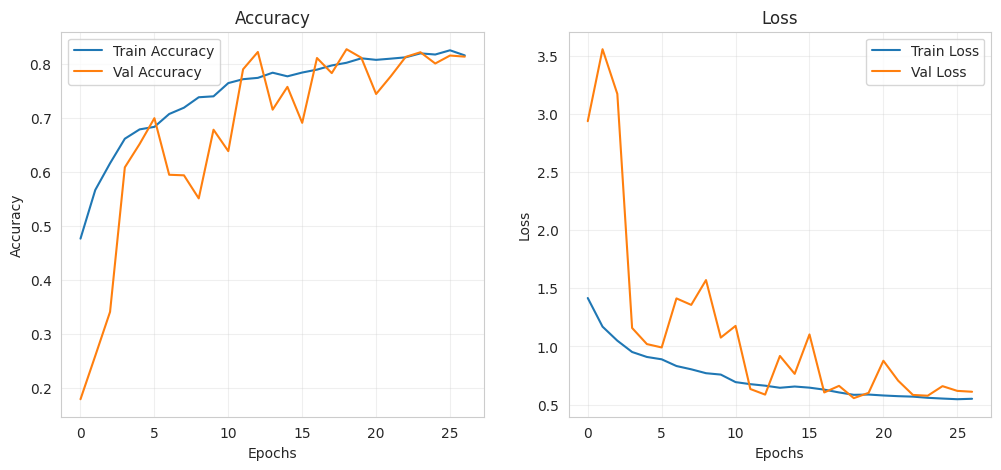

✅ Test Accuracy: 0.8180 (81.80%)
✅ Test Loss: 0.6103


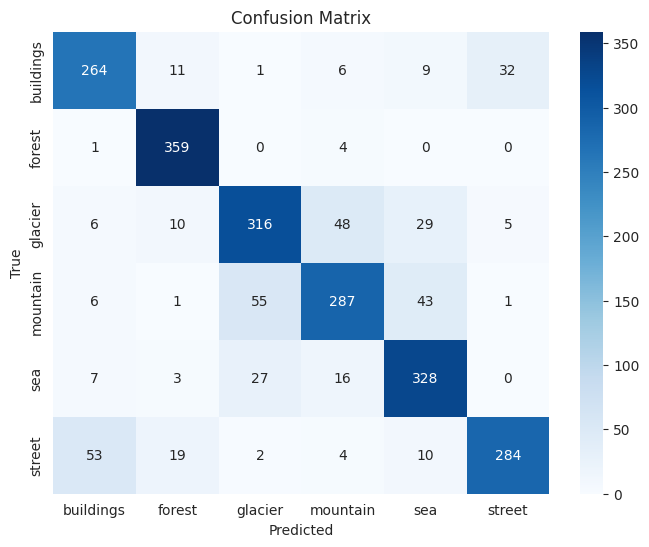


📊 Classification Report:
              precision    recall  f1-score   support

   buildings       0.78      0.82      0.80       323
      forest       0.89      0.99      0.94       364
     glacier       0.79      0.76      0.78       414
    mountain       0.79      0.73      0.76       393
         sea       0.78      0.86      0.82       381
      street       0.88      0.76      0.82       372

    accuracy                           0.82      2247
   macro avg       0.82      0.82      0.82      2247
weighted avg       0.82      0.82      0.82      2247


🔍 Eigen-CAM Görselleştirme Başlıyor...


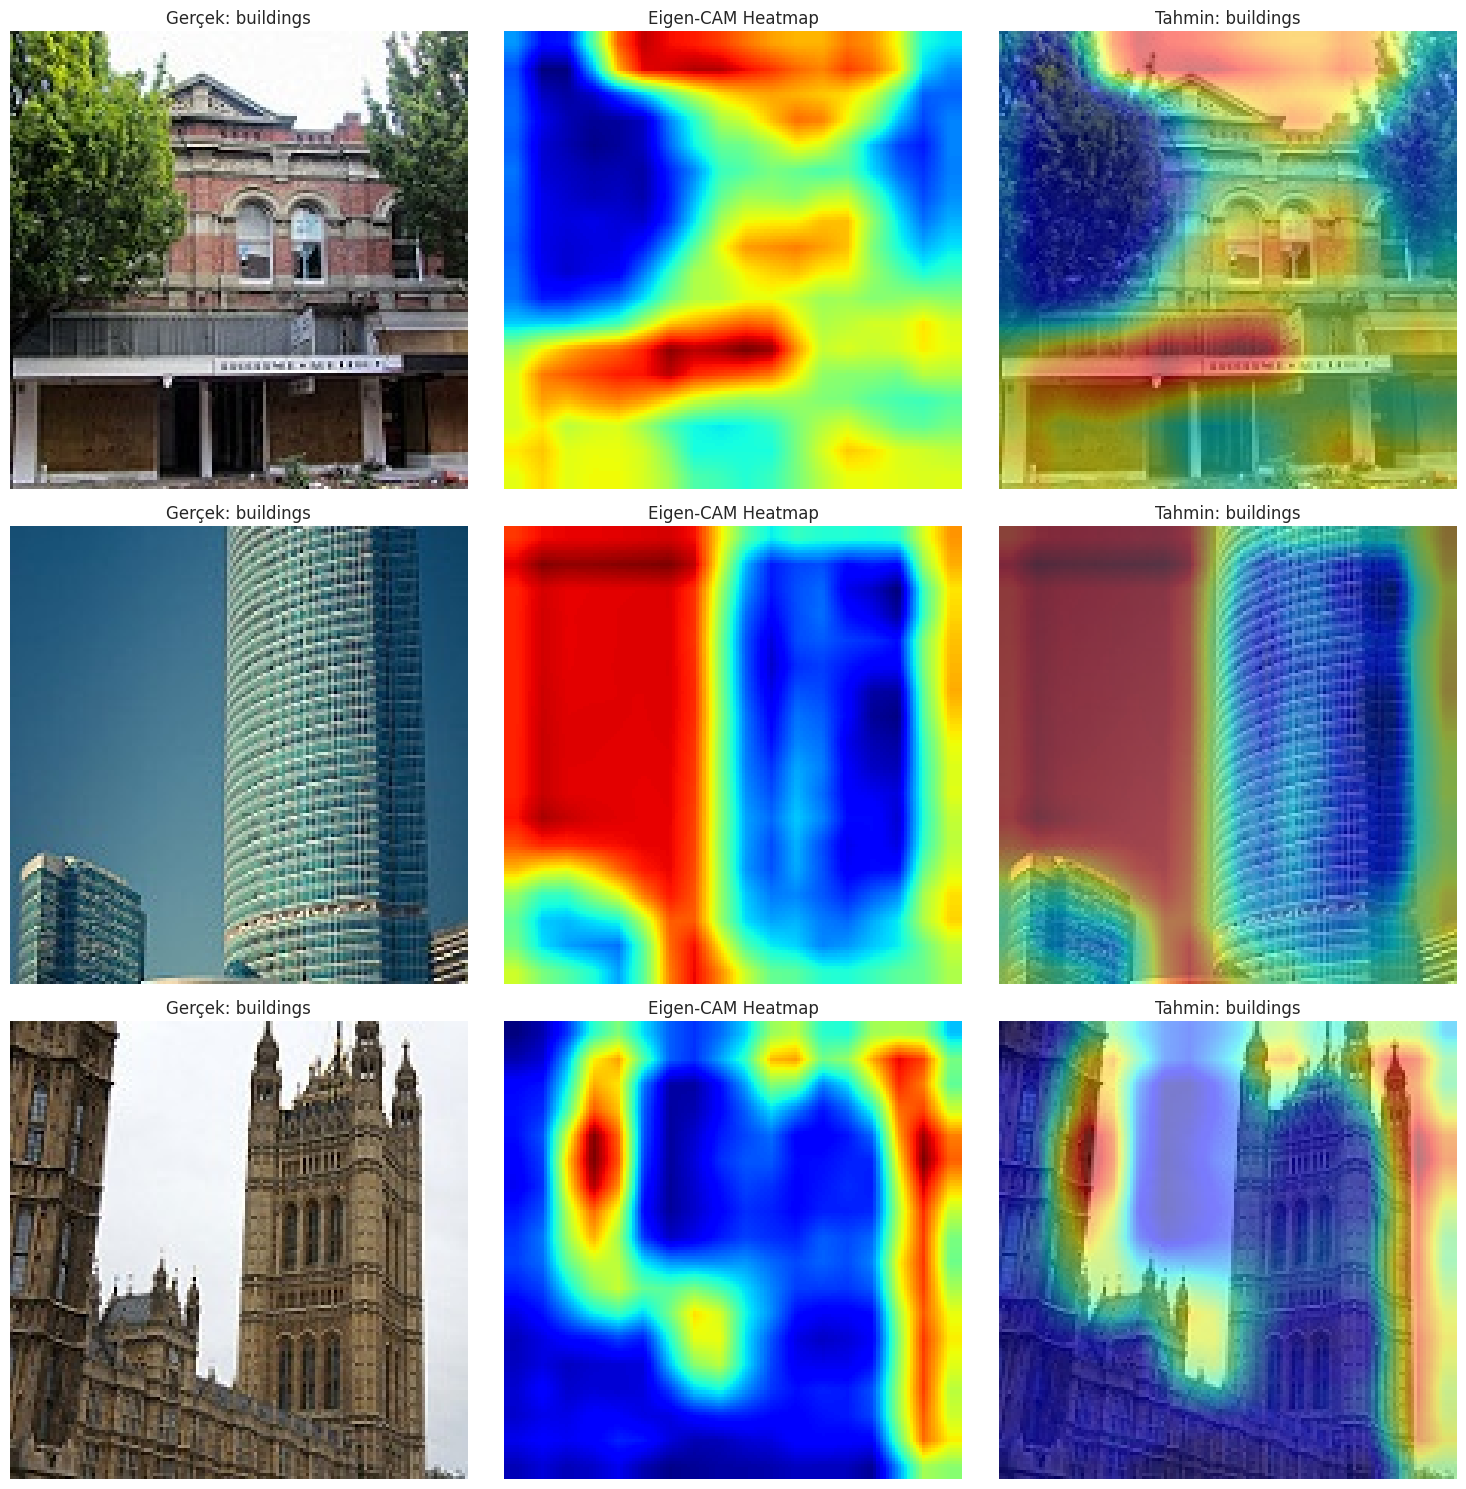

In [67]:
# Örn:
# improved_model = eğittiğin model
# improved_history = eğitim geçmişi
# test_gen_improved = test generator
# class_names = list(train_gen.class_indices.keys())

comprehensive_model_evaluation(
    improved_model,
    improved_history,
    test_gen_improved,
    class_names
)


CNN tabanlı model için Hiperparametre Optimizasyonu.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import os

# 🔹 Parametreler
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
NUM_CLASSES = 6
L2_REG = 1e-4
DROPOUT_RATE = 0.3
EPOCHS = 5

# 🔹 Intel veri seti dizinleri (Kaggle Input)
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
val_dir   = "/kaggle/input/intel-image-classification/seg_test/seg_test"

# 🔹 Data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3]
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 🔹 Tunable CNN modeli
def build_model(hp):
    model = Sequential(name='Tunable_CNN')
    
    # Convolutional katman sayısı
    for i in range(hp.Int("conv_layers", 2, 4)):
        model.add(Conv2D(
            filters=hp.Choice(f"filters_{i}", [32, 64, 128]),
            kernel_size=hp.Choice(f"kernel_size_{i}", [3,5]),
            activation='relu',
            padding='same'
        ))
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(hp.Float(f"dropout_{i}", 0.2, 0.5, step=0.1)))

    model.add(GlobalAveragePooling2D())
    
    # Dense layer
    model.add(Dense(
        units=hp.Choice("dense_units", [64, 128, 256]),
        activation='relu',
        kernel_regularizer=l2(L2_REG)
    ))
    model.add(Dropout(hp.Float("dense_dropout", 0.2, 0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Optimizer
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    if optimizer_choice == "adam":
        optimizer = Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling='log'))
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling='log'))
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling='log'), momentum=0.9)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# 🔹 Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    directory='ktuner_dir',
    project_name='intel_cnn_hyperopt'
)

# 🔹 Tuning çalıştır
tuner.search(train_gen, validation_data=val_gen, epochs=EPOCHS, batch_size=BATCH_SIZE)

# 🔹 En iyi hiperparametreler
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n✅ En iyi hiperparametreler:")
print(f"- Conv Katman Sayısı: {best_hps.get('conv_layers')}")
for i in range(best_hps.get('conv_layers')):
    print(f"  * filters_{i}: {best_hps.get(f'filters_{i}')}, kernel_size_{i}: {best_hps.get(f'kernel_size_{i}')}, dropout_{i}: {best_hps.get(f'dropout_{i}'):.2f}")
print(f"- Dense units: {best_hps.get('dense_units')}, dropout: {best_hps.get('dense_dropout'):.2f}")
print(f"- Optimizer: {best_hps.get('optimizer')}, learning rate: {best_hps.get('lr'):.5f}")


Trial 4 Complete [00h 09m 23s]
val_accuracy: 0.40799999237060547

Best val_accuracy So Far: 0.6656666398048401
Total elapsed time: 00h 38m 46s

✅ En iyi hiperparametreler:
- Conv Katman Sayısı: 3
  * filters_0: 128, kernel_size_0: 5, dropout_0: 0.20
  * filters_1: 64, kernel_size_1: 3, dropout_1: 0.30
  * filters_2: 128, kernel_size_2: 5, dropout_2: 0.20
- Dense units: 64, dropout: 0.20
- Optimizer: rmsprop, learning rate: 0.00399
